# **NB1: Parte B**

### **Imports necesarios**

In [ ]:
!pip install mpld3

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage
import skimage.filters as filters
import skimage.morphology as morphology
import skimage.exposure as exposure
from scipy import ndimage as ndi
import mpld3
mpld3.enable_notebook()  # Interactividad matplotlib para todo el notebook

# Ipywidgets:
from ipywidgets import IntSlider, FloatSlider, Checkbox, interact, fixed

Función auxiliar para mostrar una lista de imágenes (sacada del Notebook 04 de teoría):

In [ ]:
def imshow_all(*images, titles=None, cmaps=None):
    # Convertimos a imágenes de tipo float skimage (https://scikit-image.org/docs/stable/user_guide/numpy_images.html):
    images = [skimage.img_as_float(img) for img in images]
    if titles is None:
        titles = [''] * len(images)
    # Escalamos la visualización de imágenes al rango entre el máximo y el mínimo
    # valor de píxel de *todas* las imágenes a mostrar:
    vmin, vmax = min(map(np.min, images)), max(map(np.max, images))
    fig, axes = plt.subplots(nrows=1, ncols=len(images), figsize=(5.0*len(images), 5.0))
    if cmaps is None:
        cmaps = len(images)*["gray"]
    for ax, img, label, cmap in zip(axes.ravel(), images, titles, cmaps):
        ax.imshow(img, vmin=vmin, vmax=vmax, cmap=cmap)
        ax.set_title(label)

La siguiente función nos valdrá para mostrar los vídeos en el propio notebook (sacada del Notebook 01 visto en clase):

In [ ]:
from IPython.display import HTML
from base64 import b64encode

def play_video(videofilename):
    mp4 = open(videofilename,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
    <video width=400 controls>
      <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

### Código para leer ficheros desde Drive

In [ ]:
from google.colab import drive
import os
import shutil
import gdown
import zipfile


# IDs de los archivos compartidos (reemplaza con los IDs de tus archivos .zip)
file_ids = ['1Cen9C8JUsS9zEaM9r0abyyC8cfu8g1YH', '1U3l67Tw6-KsrPI9AQ9NullORE9U1G7UQ']  # Cambia estos IDs por los de tus archivos

    #https://drive.google.com/file/d/1Cen9C8JUsS9zEaM9r0abyyC8cfu8g1YH/view?usp=sharing

# Nombres locales para los archivos descargados y descomprimidos
download_paths = ['/ComputerVisionFiles.zip', '/stereopairs.zip']
extract_paths = ['', '']

# Descargar y descomprimir cada archivo
for file_id, download_path, extract_path in zip(file_ids, download_paths, extract_paths):
    # Descargar archivo
    gdown.download(f'https://drive.google.com/uc?id={file_id}', download_path, quiet=False)

    # Descomprimir el archivo ZIP
    with zipfile.ZipFile(download_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
        print(f"Archivos descomprimidos en '{extract_path}'")

### **Ejercicios recomendados**

#### **RC1A: (Completa con ejemplos extra al de la parte A de la entrega)**

Obtener los respectivos mapas de profundidad para algunas de las imágenes contenidas en el siguiente enlace http://ditec.um.es/~pedroe/stereopairs.zip. Para ello, extraer de cada imagen global las dos imágenes izquierda y derecha del par estéreo usando algún tipo de umbralizado seguido del cálculo de las dos componentes conexas rectangulares que engloban a cada imagen por separado, y la clase `cv2.StereoBM` de `OpenCV`.

Para empezar, creamos una función que se encargará de hacer el preprocesamiento de las imágenes, el cual está compuesto por:


1.   RGB -> Escala de grises
2.   Escalado
3.   Umbralizado
4.   Componentes conexas
5.   Extracción del par stereo



In [ ]:
def preprocesamiento(img, ancho=None, altura=None):
    # 1. Convertir de RGB a escala de grises:
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 2. Escalar la imagen:
    # Si ancho y altura no están definidos, usamos las dimensiones originales
    if ancho is None or altura is None:
        altura, ancho = img_gray.shape

    img_escalada = cv2.resize(img_gray, (ancho, altura))

    # 3. Aplicar umbralizado:
    _, img_thr = cv2.threshold(img_escalada, 250, 255, cv2.THRESH_BINARY)

    # 4. Identificar componentes conexas:
    ccs = cv2.connectedComponentsWithStats(255 - img_thr, connectivity=4)

    # 5. Extraer el par stereo, formado por las 2 componentes de mayor área:
    # Ordenamos por el área, quedándonos con las 2 más grandes
    componentes = sorted(ccs[2], key = lambda x: x[-1], reverse=True)[:2]

    # Ordenamos por la coordenada x para que imagenes[0] sea la imagen de la
    # izquierda e imagenes[1] sea la de la derecha
    componentes = sorted(componentes, key=lambda x: x[0])

    # Extraemos las imágenes correspondientes a las componentes
    # Imagen izquierda
    x_i, y_i, w_i, h_i, area_i = componentes[0]
    img_izq = img_gray[y_i:y_i+h_i, x_i:x_i+w_i]

    # Imagen derecha (usamos h_i y w_i para que ambas tengan el mismo tamaño)
    x_d, y_d, w_d, h_d, area_d = componentes[1]
    img_dcha = img_gray[y_d:y_d+h_i, x_d:x_d+w_i]

    return img_izq, img_dcha

Para comprobar que funciona, vamos a probar primero con la imagen `robot.jpg`:

In [ ]:
# Leer la imagen robot.jpg
img_robot = cv2.imread("stereopairs/robot.jpg")

# Aplicar el preprocesamiento
robot_izq, robot_dcha = preprocesamiento(img_robot)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(robot_izq, cv2.COLOR_BGR2RGB))
plt.title('Imagen Izquierda')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(robot_dcha, cv2.COLOR_BGR2RGB))
plt.title('Imagen Derecha')
plt.axis('off')

plt.show()

Para crear los mapas de profundidad, primero vamos a definir una serie de conceptos que nos ayuden a entender lo que vamos a obtener.

La disparidad se refiere a la diferencia en las posiciones horizontales de un mismo punto observado en las dos imágenes del par estéreo. Denotamos esta diferencia como $x-x'$, donde $x$ es la posición del punto en la imagen izquierda y $x'$ es la posición del mismo punto en la imagen derecha. Esta disparidad es inversamente proporcional a la profundidad de los objetos en la escena, mediante la siguiente fórmula:

<div style="text-align: center;">
$$x-x' = \frac{B \cdot f}{Z}$$
</div>

donde:


*   $x-x'$ es la disparidad, es decir, la diferencia entre las coordenadas horizontales del punto en ambas imágenes
*   $B$ es la distancia entre las cámaras o baseline
*   $f$ es la distancia focal de las cámaras
*   $Z$ es la profundidad de un objeto en la escena, es decir, la distancia desde el punto hasta la cámara



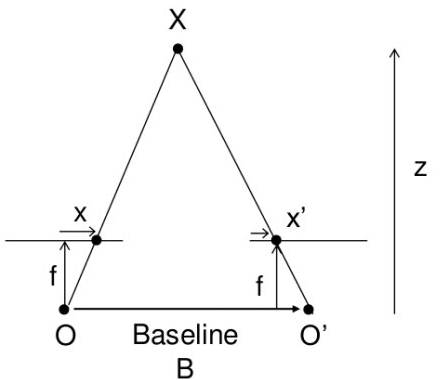

Un mapa de disparidad es una imagen en la que cada píxel representa la disparidad de un punto en la escena, y sirve para determinar la profundidad de los objetos. La clase `cv2.StereoBM` de `OpenCV`se encarga de comparar pequeñas ventanas de píxeles entre las dos imágenes y determinar la disparidad entre ellas. Vamos a considerar algunos parámetros clave para `cv2.StereoBM`, con los que tendremos que jugar para cada una de las imágenes para encontrar los mejores:


*   `numDisparities`: rango de disparidad que explorará el algoritmo. Debe ser múltiplo de 16.
*   `blockSize`: tamaño del bloque usado para comparar píxeles entre las imágenes. Debe ser impar.

Por otro lado, para representar el mapa de profundidad, necesitaríamos tener los valores de la distancia focal de las cámaras $f$ y del baseline $B$. Como en nuestro caso desconocemos estos valores, representaremos únicamente el mapa de disparidad. Teniendo todo esto en cuenta, veamos cómo obtener el mapa de disparidad para la imagen `robot.jpg`:

In [ ]:
# Crear un objeto StereoBM
stereo = cv2.StereoBM_create(numDisparities=16*2, blockSize=21)

# Calcular el mapa de disparidad
disparity = stereo.compute(robot_izq, robot_dcha)

# Mostrar el mapa de disparidad
plt.imshow(disparity, 'gray')
plt.show()

A continuación, vamos a aplicar el mismo procedimiento para otras de las imágenes contenidas en el enlace del enunciado.

In [ ]:
# Leemos la imagen almacen.jpg
img_almacen = cv2.imread("stereopairs/almacen.jpg")

# Aplicamos el preprocesamiento
almacen_izq, almacen_dcha = preprocesamiento(img_almacen)

# Crear un objeto StereoBM
stereo = cv2.StereoBM_create(numDisparities=16*2, blockSize=19)

# Calcular el mapa de disparidad
disparity = stereo.compute(almacen_izq, almacen_dcha)

# Mostrar el mapa de disparidad
plt.imshow(disparity, 'gray')
plt.show()

In [ ]:
# Leemos la imagen almacen2.jpg
img_almacen2 = cv2.imread("stereopairs/almacen2.jpg")

# Aplicamos el preprocesamiento
almacen2_izq, almacen2_dcha = preprocesamiento(img_almacen2)

# Crear un objeto StereoBM
stereo = cv2.StereoBM_create(numDisparities=16*3, blockSize=17)

# Calcular el mapa de disparidad
disparity = stereo.compute(almacen2_izq, almacen2_dcha)

# Mostrar el mapa de disparidad
plt.imshow(disparity, 'gray')
plt.show()

In [ ]:
# Leemos la imagen cementerio.jpg
img_cementerio = cv2.imread("stereopairs/cementerio.jpg")

# Aplicamos el preprocesamiento
cementerio_izq, cementerio_dcha = preprocesamiento(img_cementerio)

# Crear un objeto StereoBM
stereo = cv2.StereoBM_create(numDisparities=16*4, blockSize=15)

# Calcular el mapa de disparidad
disparity = stereo.compute(cementerio_izq, cementerio_dcha)

# Mostrar el mapa de disparidad
plt.imshow(disparity, 'gray')
plt.show()

In [ ]:
# Leemos la imagen cervantes.jpg
img_cervantes = cv2.imread("stereopairs/cervantes.jpg")

# Aplicamos el preprocesamiento
cervantes_izq, cervantes_dcha = preprocesamiento(img_cervantes)

# Crear un objeto StereoBM
stereo = cv2.StereoBM_create(numDisparities=16*3, blockSize=15)

# Calcular el mapa de disparidad
disparity = stereo.compute(cervantes_izq, cervantes_dcha)

# Mostrar el mapa de disparidad
plt.imshow(disparity, 'gray')
plt.show()

In [ ]:
# Leemos la imagen ciudad.jpg
img_ciudad = cv2.imread("stereopairs/ciudad.jpg")

# Aplicamos el preprocesamiento
ciudad_izq, ciudad_dcha = preprocesamiento(img_ciudad)

# Crear un objeto StereoBM
stereo = cv2.StereoBM_create(numDisparities=16*3, blockSize=19)

# Calcular el mapa de disparidad
disparity = stereo.compute(ciudad_izq, ciudad_dcha)

# Mostrar el mapa de disparidad
plt.imshow(disparity, 'gray')
plt.show()

In [ ]:
# Leemos la imagen escalera.jpg
img_escalera = cv2.imread("stereopairs/escalera.jpg")

# Aplicamos el preprocesamiento
escalera_izq, escalera_dcha = preprocesamiento(img_escalera)

# Crear un objeto StereoBM
stereo = cv2.StereoBM_create(numDisparities=16*2, blockSize=21)

# Calcular el mapa de disparidad
disparity = stereo.compute(escalera_izq, escalera_dcha)

# Mostrar el mapa de disparidad
plt.imshow(disparity, 'gray')
plt.show()

In [ ]:
# Leemos la imagen estatua2.jpg
img_estatua2 = cv2.imread("stereopairs/estatua2.jpg")

# Aplicamos el preprocesamiento
estatua2_izq, estatua2_dcha = preprocesamiento(img_estatua2)

# Crear un objeto StereoBM
stereo = cv2.StereoBM_create(numDisparities=16*2, blockSize=21)

# Calcular el mapa de disparidad
disparity = stereo.compute(estatua2_izq, estatua2_dcha)

# Mostrar el mapa de disparidad
plt.imshow(disparity, 'gray')
plt.show()

In [ ]:
# Leemos la imagen estatua3.jpg
img_estatua3 = cv2.imread("stereopairs/estatua3.jpg")

# Aplicamos el preprocesamiento
estatua3_izq, estatua3_dcha = preprocesamiento(img_estatua3)

# Crear un objeto StereoBM
stereo = cv2.StereoBM_create(numDisparities=16, blockSize=13)

# Calcular el mapa de disparidad
disparity = stereo.compute(estatua3_izq, estatua3_dcha)

# Mostrar el mapa de disparidad
plt.imshow(disparity, 'gray')
plt.show()

In [ ]:
# Leemos la imagen maquina.jpg
img_maquina = cv2.imread("stereopairs/maquina.jpg")

# Aplicamos el preprocesamiento
maquina_izq, maquina_dcha = preprocesamiento(img_maquina)

# Crear un objeto StereoBM
stereo = cv2.StereoBM_create(numDisparities=16*2, blockSize=15)

# Calcular el mapa de disparidad
disparity = stereo.compute(maquina_izq, maquina_dcha)

# Mostrar el mapa de disparidad
plt.imshow(disparity, 'gray')
plt.show()

In [ ]:
# Leemos la imagen pared.jpg
img_pared = cv2.imread("stereopairs/pared.jpg")

# Aplicamos el preprocesamiento
pared_izq, pared_dcha = preprocesamiento(img_pared)

# Crear un objeto StereoBM
stereo = cv2.StereoBM_create(numDisparities=16*2, blockSize=17)

# Calcular el mapa de disparidad
disparity = stereo.compute(pared_izq, pared_dcha)

# Mostrar el mapa de disparidad
plt.imshow(disparity, 'gray')
plt.show()

In [ ]:
# Leemos la imagen puerta.jpg
img_puerta = cv2.imread("stereopairs/puerta.jpg")

# Aplicamos el preprocesamiento
puerta_izq, puerta_dcha = preprocesamiento(img_puerta)

# Crear un objeto StereoBM
stereo = cv2.StereoBM_create(numDisparities=16*2, blockSize=15)

# Calcular el mapa de disparidad
disparity = stereo.compute(puerta_izq, puerta_dcha)

# Mostrar el mapa de disparidad
plt.imshow(disparity, 'gray')
plt.show()

In [ ]:
# Leemos la imagen rueda.jpg
img_rueda = cv2.imread("stereopairs/rueda.jpg")

# Aplicamos el preprocesamiento
rueda_izq, rueda_dcha = preprocesamiento(img_rueda)

# Crear un objeto StereoBM
stereo = cv2.StereoBM_create(numDisparities=16*2, blockSize=19)

# Calcular el mapa de disparidad
disparity = stereo.compute(rueda_izq, rueda_dcha)

# Mostrar el mapa de disparidad
plt.imshow(disparity, 'gray')
plt.show()

In [ ]:
# Leemos la imagen statua.jpg
img_statua = cv2.imread("stereopairs/statua.jpg")

# Aplicamos el preprocesamiento
statua_izq, statua_dcha = preprocesamiento(img_statua)

# Crear un objeto StereoBM
stereo = cv2.StereoBM_create(numDisparities=16*2, blockSize=13)

# Calcular el mapa de disparidad
disparity = stereo.compute(statua_izq, statua_dcha)

# Mostrar el mapa de disparidad
plt.imshow(disparity, 'gray')
plt.show()

En general, observamos que las imágenes con objetos cercanos a la cámara requieren valores más bajos de `numDisparities`, mientras que las imágenes con objetos más alejados necesitan valores más altos para este parámetro. Además, en imágenes que contienen muchos detalles, es preferible usar valores de `blockSize` más pequeños, ya que permite capturarlos mejor. Por otro lado, en imágenes con menos detalle o superficies suaves, valores mayores de `blockSize` generan mejores resultados.

### **Ejercicios optativos**

#### **OP1B:**

Probar con diferentes kernels el efecto del filtro lineal correspondiente sobre una imagen cualquiera descargada de Internet. P.e., operadores de sharpening, máscaras de las transparencias 32 y 34 del tema 3, filtros de Gabor, máscaras diseñadas ad-hoc, etc.

In [ ]:
! wget -q https://st1.uvnimg.com/dims4/default/8f5460f/2147483647/thumbnail/400x225/quality/75/?url=https%3A%2F%2Fuvn-brightspot.s3.amazonaws.com%2Fassets%2Fvixes%2Fp%2Fpassaro-long-tail-tit-0420-1400x800_0.jpg -O pajaro.jpg

In [ ]:
img_pajaro = cv2.cvtColor(cv2.imread("pajaro.jpg"), cv2.COLOR_BGR2RGB)
img_pajaro_gray = cv2.cvtColor(img_pajaro, cv2.COLOR_BGR2GRAY)

##### **Sharpening**

In [ ]:
# Aplicar el filtro de unsharp mask para sharpening
img_sharpening = filters.unsharp_mask(img_pajaro_gray, radius=1, amount=1.5)

imshow_all(img_pajaro_gray, img_sharpening, titles=['Imagen original', 'Sharpening'])

##### **Filtrado separable**

In [ ]:
# FILTRO 1
kernel1 = np.array([1/3, 1/3, 1/3])

# Aplicar el filtro en la dirección horizontal
img_kernel1_horizontal = ndi.convolve1d(img_pajaro_gray, kernel1, axis=1)

# Aplicar el filtro en la dirección vertical
img_kernel1 = ndi.convolve1d(img_kernel1_horizontal, kernel1, axis=0)

# FILTRO 2
kernel2 = 1/4*np.array([1, 2, 1])

# Aplicar el filtro en la dirección horizontal
img_kernel2_horizontal = ndi.convolve1d(img_pajaro_gray, kernel2, axis=1)

# Aplicar el filtro en la dirección vertical
img_kernel2 = ndi.convolve1d(img_kernel1_horizontal, kernel2, axis=0)

# FILTRO 3
kernel3 = 1/16*np.array([1, 4, 6, 4, 1])

# Aplicar el filtro en la dirección horizontal
img_kernel3_horizontal = ndi.convolve1d(img_pajaro_gray, kernel3, axis=1)

# Aplicar el filtro en la dirección vertical
img_kernel3 = ndi.convolve1d(img_kernel1_horizontal, kernel3, axis=0)

# FILTRO 4
kernel4h = 1/4*np.array([1, 2, 1])

# Aplicar el filtro en la dirección horizontal
img_kernel3_horizontal = ndi.convolve1d(img_pajaro_gray, kernel4h, axis=1)

kernel4v = np.array([-1, 0, 1])

# Aplicar el filtro en la dirección vertical
img_kernel4 = ndi.convolve1d(img_kernel1_horizontal, kernel4v, axis=0)

# FILTRO 5
kernel5 = 1/2*np.array([1,-2, 1])

# Aplicar el filtro en la dirección horizontal
img_kernel5_horizontal = ndi.convolve1d(img_pajaro_gray, kernel5, axis=1)

# Aplicar el filtro en la dirección vertical
img_kernel5 = ndi.convolve1d(img_kernel1_horizontal, kernel5, axis=0)

imshow_all(img_pajaro_gray, img_kernel1, img_kernel2, img_kernel3, img_kernel4, img_kernel5,
           titles=['Imagen original', 'Filtrado separable 1', 'Filtrado separable 2', 'Filtrado separable 3', 'Filtrado separable 4', 'Filtrado separable 5'])

##### **Filtro de media**

In [ ]:
# Aplicar el filtro de media
img_mean = filters.rank.mean(img_pajaro_gray, np.full((3, 3), 1/9))

imshow_all(img_pajaro_gray, img_mean, titles=['Imagen original', 'Filtro de media'])

##### **Filtro Laplaciano**

In [ ]:
# Aplicar el filtro de laplace de tamaño 3x3
img_laplace = filters.laplace(img_pajaro_gray, ksize=3)

imshow_all(img_pajaro_gray, img_laplace, titles=['Imagen original', 'Filtro Laplaciano'])

##### **Filtro Gaussiano**

In [ ]:
# Aplicar el filtro Gaussiano con sigma=1
img_gaussian_1 = filters.gaussian(img_pajaro_gray, sigma=1)

# Aplicar el filtro Gaussiano con sigma=5
img_gaussian_5 = filters.gaussian(img_pajaro_gray, sigma=5)

imshow_all(img_pajaro_gray, img_gaussian_1, img_gaussian_5, titles=['Imagen original', 'Filtro Gaussiano con sigma=1', 'Filtro Gaussiano con sigma=5'])

##### **Filtro de la Laplaciana de la Gaussiana**

In [ ]:
# OPCIÓN 1: LoG
# Aplicar el filtro Gaussiano para suavizar la imagen
img_gaussian = filters.gaussian(img_pajaro_gray, sigma=2)

# Aplicar el filtro Laplaciano a la imagen suavizada
img_log = filters.laplace(img_gaussian, ksize=3)

# OPCIÓN 2: Aproximación por DoG
# Aplicar dos filtros Gaussianos con sigma diferente
img_gaussian1 = filters.gaussian(img_pajaro_gray, sigma=1)
img_gaussian2 = filters.gaussian(img_pajaro_gray, sigma=2)

# Aproximar la Laplaciana de la Gaussiana por la diferencia de Gaussianas
img_dog = img_gaussian1 - img_gaussian2

imshow_all(img_pajaro_gray, img_log, img_dog, titles=['Imagen original', 'Filtro LoG', 'Filtro DoG'])

##### **Filtrado de gradiente**

In [ ]:
# Aplicar el filtro de Roberts
img_roberts = filters.roberts(img_pajaro_gray)

# Aplicar el filtro de Sobel
img_sobel = filters.sobel(img_pajaro_gray)

imshow_all(img_pajaro_gray, img_roberts, img_sobel, titles=['Imagen original', 'Roberts', 'Sobel'])

In [ ]:
# Aplicar el filtro de Sobel X
img_sob_v = filters.sobel_v(img_pajaro_gray)

# Aplicar el filtro de Sobel Y
img_sob_h = filters.sobel_h(img_pajaro_gray)

imshow_all(img_pajaro_gray, img_sob_v, img_sob_h, titles=['Imagen original', 'Sobel X', 'Sobel Y'])

##### **Filtros de Gabor**

In [ ]:
# Definir los parámetros de los filtros de Gabor
sigmas = [2, 3]
frequencies = [0.15, 0.25]
nangles = 12
angles = [theta * np.pi / nangles for theta in range(nangles)]

# Preparar el tamaño de la cuadrícula para la visualización
rows = len(sigmas) * len(frequencies)
cols = len(angles)
fig, axs = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 2.5))

# Aplicar los filtros de Gabor y mostrar el resultado en cada combinación
row = 0
for sigma in sigmas:
    for omega in frequencies:
        col = 0
        for theta in angles:
            img_filtered, _ = filters.gabor(img_pajaro_gray, frequency=omega, theta=theta, sigma_x=sigma, sigma_y=sigma)

            # Mostrar la imagen filtrada
            axs[row, col].imshow(img_filtered, cmap="gray")
            axs[row, col].set_axis_off()
            axs[row, col].set_title(fr"σ={sigma}, ω={omega:.2f}, θ={theta:.2f}")
            col += 1
        row += 1

plt.tight_layout()
plt.show()

##### **Máscaras diseñadas Ad-hoc**

In [ ]:
# Máscara de suavizado (filtro de media)
mascara_suavizado = np.array([[1/9, 1/9, 1/9],
                              [1/9, 1/9, 1/9],
                              [1/9, 1/9, 1/9]])

# Máscara de realce de bordes (filtro Laplaciano)
mascara_bordes = np.array([[-1, -1, -1],
                           [-1,  8, -1],
                           [-1, -1, -1]])

# Máscara de detector de esquinas
mascara_esquinas = np.array([[-2, -1,  0],
                             [-1,  1,  1],
                             [ 0,  1,  2]])

# Aplicar las máscaras
img_suavizado = ndi.convolve(img_pajaro_gray, mascara_suavizado)
img_bordes = ndi.convolve(img_pajaro_gray, mascara_bordes)
img_esquinas = ndi.convolve(img_pajaro_gray, mascara_esquinas)

imshow_all(img_pajaro_gray, img_suavizado, img_bordes, img_esquinas, titles=['Imagen original', 'Máscara suavizado', 'Máscara bordes', 'Máscara esquinas'])

#### **OP1D:**

Intentar reproducir un *depthmap* completo manualmente (sin usar la clase `cv2.StereoBM`).

Inspirándonos en el funcionamiento de la clase `cv2.StereoBM`, crearemos una función que genere el mapa de disparidad para un par stereo. Los pasos serán los siguientes:


1.   La función tomará como parámetros las dos imágenes del par stereo, junto con `numDisparities` y `blockSize`, equivalentes a los mismos parámetros de `cv2.StereoBM`. Recordamos del ejercicio RC1A:

  *   `numDisparities`: rango máximo de disparidad que explorará el algoritmo.
  *   `blockSize`: tamaño del bloque usado para comparar píxeles entre las imágenes.


2.   Se usará un bucle para recorrer cada píxel de la imagen izquierda, calculando `h`, la altura de la imagen, y `w`, su anchura. Para evitar salir de los límites de la imagen al extraer bloques, calcularemos la mitad de `blockSize`, a la que llamaremos `halfBlockSize`. Luego, recorreremos la imagen en la dirección $x$ desde `halfBlockSize` hasta `w-halfBlockSize`, y en la dirección $y$ desde `halfBlockSize` hasta `h-halfBlockSize`. El bloque se definirá a partir del pixel central `(x, y)` y abarcará un área que va desde `(x-halfBlockSize, y-halfBlockSize)` hasta `(x+halfBlockSize, y+halfBlockSize)`, asegurando que el bloque esté completamente contenido dentro de los límites de la imagen.


3. Se utilizarán dos variables, `best_disparity` para almacenar la mejor disparidad encontrada para el píxel actual, y `min_SAD` para almacenar la mejor similitud obtenida entre bloques. El SAD (suma de diferencias absolutas) es una medida de similitud entre bloques de imágenes que se calcula sumando las diferencias absolutas entre cada píxel en el bloque original y el píxel correspondiente en el bloque comparado. Esta suma representa la norma L1 (o distancia de Manhattan) entre ambos bloques. El cálculo procederá de la siguiente manera:

  i) Para cada píxel `(x, y)` se inicializan las variables `best_disparity` y `min_SAD`.

  ii) Se usa un bucle para recorrer todas las posibles disparidades `d` desde `0` hasta `numDisparities`. Para cada valor de `d`, se extraerá el bloque correspondiente en la imagen derecha, desplazado `d` píxeles hacia la izquierda en relación con el respectivo bloque de la imagen izquierda. Además, se comprueba que el bloque de la imagen derecha no se salga de los límites de la imagen.

  iii) Una vez extraídos ambos bloques, se calcula el SAD entre el bloque izquierdo y el bloque derecho desplazado, midiendo así la similitud entre ellos.

  iv) Si el SAD actual es menor que el mínimo SAD encontrado hasta el momento para el píxel `(x, y)`, se actualizan `min_SAD` y `best_disparity` con los valores actuales.

  v) Una vez recorridas todas las posibles disparidades `d` para el píxel `(x, y)`, se guarda `best_disparity` en la posición `(x, y)` del mapa de disparidad, `disparity_map`.




In [ ]:
def disparity_map(left_img, right_img, numDisparities, blockSize):
    # Se inicializa el mapa de disparidad, con las dimensiones de la imagen izquierda
    h, w = left_img.shape
    disparity_map = np.zeros((h, w), dtype=np.float32)

    # Calcular la mitad del tamaño del bloque
    halfBlockSize = blockSize // 2

    # Recorrer cada pixel de la imagen izquierda
    for x in range(halfBlockSize, w - halfBlockSize):
        for y in range(halfBlockSize, h - halfBlockSize):
            # Extraer el bloque de la imagen de la izquierda
            block_left = left_img[y - halfBlockSize:y + halfBlockSize + 1, x - halfBlockSize:x + halfBlockSize + 1]

            # Variables para almacenar la mejor disparidad y su similitud
            best_disparity = 0
            min_SAD = float('inf')

            # Bucle para recorrer cada posible disparidad
            for d in range(numDisparities):
                # Verificar que el bloque derecho no se salga de los límites
                if x - d - halfBlockSize < 0:
                    break

                # Extraer el bloque de la imagen derecha
                block_right = right_img[y - halfBlockSize:y + halfBlockSize + 1, x - d - halfBlockSize:x - d + halfBlockSize + 1]

                # Calcular la suma de diferencias absolutas (SAD)
                SAD = np.sum(np.abs(block_left - block_right))

                # Si encontramos un SAD menor, actualizamos la mejor disparidad
                if SAD < min_SAD:
                    min_SAD = SAD
                    best_disparity = d

            # Guardar la mejor disparidad encontrada en el mapa de disparidad
            disparity_map[y, x] = best_disparity

    return disparity_map


Vamos a probar a usar la función con el par stereo del robot usado en el ejercicio RC1A. Para obtener la imagen izquierda y la imagen derecha, usaremos la función `preprocesamiento` definida en dicho ejercicio.

In [ ]:
# Leer la imagen robot.jpg
img_robot = cv2.imread("stereopairs/robot.jpg")

# Aplicar el preprocesamiento
robot_izq, robot_dcha = preprocesamiento(img_robot)

# Parámetros de la función
numDisparities = 16*2  # Rango de disparidad a explorar
blockSize = 21        # Tamaño del bloque para comparar

# Llamada a la función disparity_map
disparity = disparity_map(robot_izq, robot_dcha, numDisparities, blockSize)

# Mostrar el resultado
plt.imshow(disparity, cmap='plasma')
plt.colorbar()
plt.title("Mapa de Disparidad")
plt.show()

#### **OP1H:**

Eliminar el ruido y/o aumentar el rango dinámico (contraste) de una imagen deteriorada propia (por ejemplo, una tomada en condiciones de muy poca luz, o una a la que se añada cierto ruido artificial).

##### 1. Eliminar ruido de una imagen con ruido artificial:

In [ ]:
# Cargar la imagen en escala de grises
img_color = cv2.cvtColor(cv2.imread("ComputerVisionFiles/escritorio.jpg"), cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

# Agregar ruido gaussiano
mean = 0
sigma = 25
noise = np.random.normal(mean, sigma, img_gray.shape).astype(np.uint8)
img_noisy = cv2.add(img_gray, noise)

plt.imshow(img_noisy, cmap='gray');

In [ ]:
size = 5
neighborhood_square = np.full((size,size), 1, dtype="uint8")

# 1. Filtro gaussiano
img_gaussian_noisy = filters.gaussian(img_noisy, sigma=size)

# 2. Filtro de media
img_mean_noisy = filters.rank.mean(img_noisy, neighborhood_square)

# 3. Filtro de mediana
img_median_noisy = filters.rank.median(img_noisy, neighborhood_square)

imshow_all(img_gray, img_noisy, img_gaussian_noisy, img_mean_noisy, img_median_noisy,
           titles = ['Imagen original', 'Imagen con ruido', 'Filtro gaussiano', 'Filtro de media', 'Filtro de mediana'])

Se observa que el filtro gaussiano es el que mejor funciona para eliminar el ruido en este caso, y que el filtro de mediana empeora la imagen.

In [ ]:
# Agregar ruido de tipo "sal y pimienta"
size = 5
neighborhood_square = np.full((size,size), 1, dtype="uint8")
noise = np.random.rand(*img_gray.shape)
img_noisy_sp = img_gray.copy()
img_noisy_sp[noise > 0.8] = 255
img_noisy_sp[noise < 0.2] = 0

plt.imshow(img_noisy_sp, cmap='gray');

In [ ]:
# 1. Filtro gaussiano
img_gaussian_noisy_sp = filters.gaussian(img_noisy_sp, sigma=1)

# 2. Filtro de media
img_mean_noisy_sp = filters.rank.mean(img_noisy_sp, neighborhood_square)

# 3. Filtro de mediana
img_median_noisy_sp = filters.rank.median(img_noisy_sp, neighborhood_square)

imshow_all(img_gray, img_noisy_sp, img_gaussian_noisy_sp, img_mean_noisy_sp, img_median_noisy_sp,
           titles = ['Imagen original', 'Imagen con ruido', 'Filtro gaussiano', 'Filtro de media', 'Filtro de mediana'])

En el caso de ruido de tipo "sal y pimienta", el filtro que mejor funciona es el filtro de mediana.

##### 2. Aumentar el contraste de una imagen tomada en condiciones de poca luz:

In [ ]:
# Cargar la imagen en escala de grises
img_dark = cv2.cvtColor(cv2.imread("ComputerVisionFiles/oscura.jpg"), cv2.COLOR_BGR2RGB)
img_dark_gray = cv2.cvtColor(img_dark, cv2.COLOR_BGR2GRAY)

plt.imshow(img_dark_gray, cmap='gray');

In [ ]:
# Función para mostrar los histogramas (sacada del Notebook 04 de teoría)
def plot_hist(image, axes, bins=256):
    image = skimage.img_as_float(image)
    ax_cdf = axes.twinx()
    axes.hist(image.ravel(), bins=bins, histtype='step', color='black')
    axes.set_xlabel('Pixel intensity')
    axes.set_xlim(0, 1)
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

In [ ]:
# 1. Estiramiento de histograma (stretching):
p2, p98 = np.percentile(img_dark_gray, (2, 98))
img_rescale = exposure.rescale_intensity(img_dark_gray, in_range=(p2, p98))

# 2. Ecualización de histograma:
img_eq = exposure.equalize_hist(img_dark_gray)

# 3. Ecualización adaptativa (CLAHE):
img_adapteq = exposure.equalize_adapthist(img_dark_gray, clip_limit=0.03)

imshow_all(img_dark_gray, img_rescale, img_eq, img_adapteq, titles=["Imagen original", "Estiramiento de histograma", "Ecualización de histograma", "Ecualización adaptativa (CLAHE)"])
fig, axes = plt.subplots(1,4,figsize=(20.,5.))
for i,im in enumerate([img_dark_gray, img_rescale, img_eq, img_adapteq]):
  plot_hist(im, axes[i], bins=256)
plt.show();

#### **OP1L: (TARDA MUCHO EN EJECUTAR)**

Implementar la reconstrucción de una imagen a partir de sus bordes utilizando el método de compresión de Elder-Zucker. Para ello, primero se obtendrá una imagen binaria de bordes usando el operador de Canny, que luego se dilata mediante operadores morfológicos en OpenCV con un elemento estructural de tamaño configurable. A continuación, se muestrearán los valores de la imagen
original en los píxeles activos de la imagen dilatada, obteniendo una nueva imagen donde esos píxeles mantienen el valor original, mientras que los demás son cero. Posteriormente, y para mejorar la eficiencia del posterior proceso de difusión, se inicializará la imagen con una aproximación inicial basada en la
transformada de distancia, asignando a cada píxel negro en la imagen inicial el color del borde inicializado más cercano. Finalmente, se realizará un proceso iterativo de difusión, donde cada píxel no prefijado en la imagen de bordes coloreados de partida será actualizado con la media de sus vecinos, repitiendo el proceso un número preespecificado de iteraciones. Se podrá realizar la implementación bien íntegramente en Python (usando Numpy), o bien implementando algunas de sus fases (transformada de distancia y/o proceso iterativo de difusión) mediante el correspondiente wrapper de C. Un ejemplo de las etapas del
proceso se puede encontrar en las transparencias 56 y 57 del tema 3, y un ejemplo de construcción de wrappers de C en el notebook OtsuContoursHomog2DWrappers.ipynb.

**Paso 1.** Cargar la imagen y obtener sus bordes usando el operador de Canny:

In [ ]:
# Cargar la imagen en escala de grises
img_color = cv2.cvtColor(cv2.imread("ComputerVisionFiles/escritorio.jpg"), cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

# Aplicar el detector de bordes de Canny
img_edges = cv2.Canny(img_gray, threshold1=100, threshold2=200)

plt.imshow(img_edges, cmap='gray');

**Paso 2.** Dilatación de bordes mediante operadores morfológicos con un elemento estructural:

In [ ]:
# Crear un elemento estructural (kernel) para dilatación
kernel_size = 8  # Tamaño configurable
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))

# Dilatar los bordes
img_dilated_edges = cv2.dilate(img_edges, kernel)

plt.imshow(img_dilated_edges, cmap='gray');

**Paso 3.** Muestrear los valores de la imagen original en los píxeles activos:

In [ ]:
# Crear una imagen en negro con el mismo tamaño que la imagen en color
img_sampled = np.zeros_like(img_color)

# Convertir la imagen binaria de bordes dilatados a tres canales
img_dilated_edges_3ch = cv2.merge([img_dilated_edges, img_dilated_edges, img_dilated_edges])

# Muestrear los colores de la imagen original en los píxeles donde img_dilated_edges != 0
img_sampled[img_dilated_edges_3ch != 0] = img_color[img_dilated_edges_3ch != 0]

plt.imshow(img_sampled);

**Paso 4.** Inicialización usando la Transformada de Distancia:

In [ ]:
def distance_transform(image):
    """
    Calcula la transformada de distancia y la posición del borde más cercano para cada píxel de fondo.

    Parámetros:
        image (np.array): Imagen binaria donde los bordes son cero y el fondo son valores distintos de cero.

    Devuelve:
        dist_transform (np.array): Matriz con la distancia al borde más cercano para cada píxel de fondo.
        nearest_y (np.array): Coordenada Y del borde más cercano para cada píxel de fondo.
        nearest_x (np.array): Coordenada X del borde más cercano para cada píxel de fondo.
    """
    # Obtener coordenadas de los píxeles de borde
    edges_y, edges_x = np.where(image == 0)

    # Crear matrices para la distancia y las posiciones de borde más cercanas
    dist_transform = np.zeros(image.shape)
    nearest_y = np.zeros_like(image, dtype=int)
    nearest_x = np.zeros_like(image, dtype=int)

    # Calcular la distancia al borde más cercano para cada píxel de fondo
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            if image[y, x] > 0:  # Solo para píxeles de fondo
                # Calcular distancias a cada píxel de borde y encontrar el más cercano
                distances = np.sqrt((edges_y - y)**2 + (edges_x - x)**2)
                min_dist_index = np.argmin(distances)
                dist_transform[y, x] = distances[min_dist_index]
                nearest_y[y, x] = edges_y[min_dist_index]
                nearest_x[y, x] = edges_x[min_dist_index]

    return dist_transform, nearest_y, nearest_x

Esta función es demasiado ineficiente, y puede tardar demasiado en compilar. Por ello, implementamos la versión más eficiente vista en clase, que hace dos pasadas, una hacia delante, comparando cada píxel con sus píxeles vecinos N y W, y otra segunda pasada hacia atrás, comparando cada píxel con sus píxeles vecinos S y E.

In [ ]:
def efficient_distance_transform(image):
    """
    Calcula la transformada de distancia y guarda las posiciones del borde más cercano usando
    el algoritmo de pasada adelante y atrás.

    Parámetros:
        image (np.array): Imagen binaria donde los bordes son cero y el fondo son valores distintos de cero.

    Devuelve:
        dist_transform (np.array): Matriz con la distancia al borde más cercano para cada píxel de fondo.
        nearest_y (np.array): Coordenada Y del borde más cercano para cada píxel de fondo.
        nearest_x (np.array): Coordenada X del borde más cercano para cada píxel de fondo.
    """
    # Inicializar matriz de distancia con valores grandes para el fondo y 0 para los bordes
    dist_transform = np.where(image == 0, 0, 1)

    # Inicializar matrices para almacenar las posiciones de borde más cercanas
    nearest_y = np.zeros_like(image, dtype=int)
    nearest_x = np.zeros_like(image, dtype=int)

    # Configurar posiciones iniciales para los píxeles de borde (píxeles activos)
    edges_y, edges_x = np.where(image == 0)
    for y, x in zip(edges_y, edges_x):
        nearest_y[y, x] = y
        nearest_x[y, x] = x

    # Obtener dimensiones de la imagen
    rows, cols = dist_transform.shape

    # Primera pasada: adelante (de arriba-izquierda a abajo-derecha)
    for y in range(rows):
        for x in range(cols):
            if image[y, x] > 0:  # Solo calcular para píxeles de fondo
                # Actualizar distancia y posición usando el píxel superior (N) y el píxel izquierdo (W)
                dist_N = dist_transform[y-1, x] if y > 0 else np.inf
                dist_W = dist_transform[y, x-1] if x > 0 else np.inf
                # Tomar el mínimo
                dist_transform[y, x] = min(dist_N + 1, dist_W + 1)
                # Almacenar la posición del borde más cercano
                if dist_N < dist_W:
                    nearest_y[y, x] = nearest_y[y-1, x]
                    nearest_x[y, x] = nearest_x[y-1, x]
                else:
                    nearest_y[y, x] = nearest_y[y, x-1]
                    nearest_x[y, x] = nearest_x[y, x-1]

    # Segunda pasada: hacia atrás (de abajo-derecha a arriba-izquierda)
    for y in range(rows - 1, -1, -1):
        for x in range(cols - 1, -1, -1):
            if image[y, x] > 0:  # Solo calcular para píxeles de fondo
                # Actualizar distancia y posición usando el píxel inferior (S) y el píxel derecho (E)
                dist_S = dist_transform[y+1, x] if y < rows - 1 else np.inf
                dist_E = dist_transform[y, x+1] if x < cols - 1 else np.inf
                # Tomar el mínimo
                dist_transform[y, x] = min(dist_transform[y, x], dist_S + 1, dist_E + 1)
                # Almacenar la posición del borde más cercano
                if dist_S < dist_transform[y, x]:
                    nearest_y[y, x] = nearest_y[y+1, x]
                    nearest_x[y, x] = nearest_x[y+1, x]
                elif dist_E < dist_transform[y, x]:
                    nearest_y[y, x] = nearest_y[y, x+1]
                    nearest_x[y, x] = nearest_x[y, x+1]

    return dist_transform, nearest_y, nearest_x

In [ ]:
# Calcular transformada de distancia y etiquetas de bordes más cercanos
dist_transform, nearest_y, nearest_x = efficient_distance_transform(img_dilated_edges)

# Inicializar la imagen reconstruida
img_reconstructed = np.zeros_like(img_color)

# Asignar colores del borde más cercano
for i in range(img_color.shape[0]):
    for j in range(img_color.shape[1]):
        y = nearest_y[i, j]
        x = nearest_x[i, j]
        img_reconstructed[i, j] = img_color[y, x]

plt.imshow(img_reconstructed);

In [ ]:
def iterative_diffusion(img_reconstructed, img_dilated_edges, iterations):
    """
    Realiza un proceso iterativo de difusión sobre la imagen reconstruida.

    Parámetros:
        img_reconstructed (np.array): Imagen reconstruida donde se aplicará la difusión.
        img_dilated_edges (np.array): Imagen de bordes dilatados para determinar dónde no difundir.
        iterations (int): Número de iteraciones para la difusión.

    Devuelve:
        img_difusion (np.array): Imagen resultante después del proceso de difusión.
    """
    img_difusion = img_reconstructed.copy()

    # Realizar la difusión iterativa
    for iteration in range(iterations):
        img_temp = img_difusion.copy()

        for i in range(1, img_dilated_edges.shape[0] - 1):
            for j in range(1, img_dilated_edges.shape[1] - 1):
                if img_dilated_edges[i, j] == 0:  # Solo difundir en píxeles no fijados
                    # Obtener los vecinos (N, S, E, O)
                    neighbors = [
                        img_temp[i-1, j],  # Norte
                        img_temp[i+1, j],  # Sur
                        img_temp[i, j-1],  # Oeste
                        img_temp[i, j+1]   # Este
                    ]
                    # Calcular la media de los vecinos
                    img_temp[i, j] = np.mean(neighbors, axis=0)

        img_difusion = img_temp

    return img_difusion

In [ ]:
iterations = 5
img_result = iterative_diffusion(img_reconstructed, img_dilated_edges, iterations)

plt.imshow(img_result);

In [ ]:
imshow_all(img_color, img_result, titles=['Imagen original', 'Reconstrucción'])